In [213]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap
from pylab import rcParams
import seaborn as sns
from collections import defaultdict
import re

import pycountry as pyc

import nltk
from nltk.tokenize import sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer, normalize
from nltk.sentiment.util import demo_liu_hu_lexicon

%matplotlib inline
rcParams['figure.figsize'] = 12, 18

In [10]:
emails = pd.read_csv("hillary-clinton-emails/Emails.csv")

First we need to prepare our data for analysis. The goal of this task to analyse Hillary Clinton's opinion about different countries. For the dataset we will take only messages sent by her and will use only ExtractedBodyText column to exclude the influence of forwarded and copied messages. We also remove all non alphabetical chars.

In [11]:
persons = pd.read_csv("hillary-clinton-emails/Persons.csv")

In [12]:
hillaryid = persons[persons.Name == "Hillary Clinton"].Id.values

In [215]:
hilaryemails = emails[emails.SenderPersonId == hillaryid[0]]['ExtractedBodyText'].fillna('nan').copy()
hilaryemails = hilaryemails.apply(lambda x: re.sub('[^a-zA-Z\-]+', ' ', x))

Here we define a function to evaluate our sentiment scores using two inbuild functions

In [254]:
vader_sentim_analyzer = SentimentIntensityAnalyzer()
emttoscore={'Negative':-1,'Neutral':0,'Positive':1}

def sentiment_dection(emailtext, sentclsf = 'Vader'):
    if sentclsf == 'Vader':
        score = vader_sentim_analyzer.polarity_scores(emailtext)['compound']
    else:
        score = emttoscore[demo_liu_hu_lexicon(emailtext)]
    return score

Our approach will consist of several steps:
    1. Go through all emails and return compound score using SentimentIntensityAnalyzer.
    2. check appearance of each country name in normal, upper and lower case. We also check occurence of alpha_3 codes. We don't use alpha_2 as it will be too ambigous, examples: FM for 'Micronesia, Federated States of', NO for 'Norway', ID for 'Indonesia' etc. Plus two latters codes have some intersections with USA states.
    3. Perform adhoc checks for several countries.
    4. Count number of emails where particular country has occured.

In [255]:
def sentiment_email_analysis(sentclsf = 'Vader'):
    countrysentiment = defaultdict(lambda: 0)
    countrycount = defaultdict(lambda: 0)
    
    for row in hilaryemails.iteritems():
        emailtext = row[1]

#         score = sentim_analyzer.polarity_scores(emailtext)['compound']
        score = sentiment_dection(emailtext, sentclsf)
    
        for key in pyc.countries.indices.get('name').keys():
            if (key in emailtext) or (key.lower() in emailtext) or (key.upper() in emailtext) or \
            (' '+pyc.countries.indices.get('name')[key].alpha_3+' ' in emailtext):
    #         (' '+pyc.countries.indices.get('name')[key].alpha_2+' ' in row.ExtractedBodyText) or \
                countrysentiment[key] += score
                countrycount[key] += 1

            if key == 'Korea, Republic of':
                country = 'South Korea'
                if (country in emailtext) or \
                (country.lower() in emailtext) or \
                (country.upper() in emailtext):
                    countrysentiment[key] += score
                    countrycount[key] += 1

            if key == 'Syrian Arab Republic':
                country = 'Syria'
                if (country in emailtext) or \
                (country.lower() in emailtext) or \
                (country.upper() in emailtext):
                    countrysentiment[key] += score
                    countrycount[key] += 1

            if key == 'Korea, Democratic People\'s Republic of':
                country = 'North Korea'
                if (country in emailtext) or \
                (country.lower() in emailtext) or \
                (country.upper() in emailtext):
                    countrysentiment[key] += score
                    countrycount[key] += 1

            if key == 'Palestine, State of\'s Republic of':
                country = 'Palestine'
                if (country in emailtext) or \
                (country.lower() in emailtext) or \
                (country.upper() in emailtext):
                    countrysentiment[key] += score
                    countrycount[key] += 1

            if key == 'United Kingdom':
                country1, country2 = 'UK', 'England'
                if (country1 in emailtext) or \
                (country1.upper() in emailtext) or \
                (country2 in emailtext) or \
                (country2.upper() in emailtext) or \
                (country2.lower() in emailtext):
                    countrysentiment[key] += score
                    countrycount[key] += 1

            if key == 'Russian Federation':
                country = 'Russia'
                if (country in emailtext) or \
                (country.lower() in emailtext) or \
                (country.upper() in emailtext):
                    countrysentiment[key] += score
                    countrycount[key] += 1

            if key == 'Moldova, Republic of':
                country = 'Moldova'
                if (country in emailtext) or \
                (country.lower() in emailtext) or \
                (country.upper() in emailtext):
                    countrysentiment[key] += score
                    countrycount[key] += 1

            if key == 'United States':
                country = 'USA'
                if (country in emailtext) or \
                (country.lower() in emailtext) or \
                (country.upper() in emailtext):
                    countrysentiment[key] += score
                    countrycount[key] += 1

            if key == 'Taiwan, Province of China':
                country = 'Taiwan'
                if (country in emailtext) or \
                (country.lower() in emailtext) or \
                (country.upper() in emailtext):
                    countrysentiment[key] += score
                    countrycount[key] += 1

        if (' EU ' in emailtext):
            countrysentiment['EU'] += score
            countrycount['EU'] += 1
        
    tmp1 = pd.DataFrame.from_dict(countrysentiment, orient='index', )
    tmp2 = pd.DataFrame.from_dict(countrycount, orient='index')
    return pd.concat([tmp1, tmp2], axis=1)

Now we can display the polarity scores sorting them from negative to positive.

In [195]:
df = sentiment_email_analysis()
df.columns=['Sentiment','Freq']
df.sort_values(['Sentiment'],ascending=True, inplace=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]),
 <a list of 63 Text xticklabel objects>)

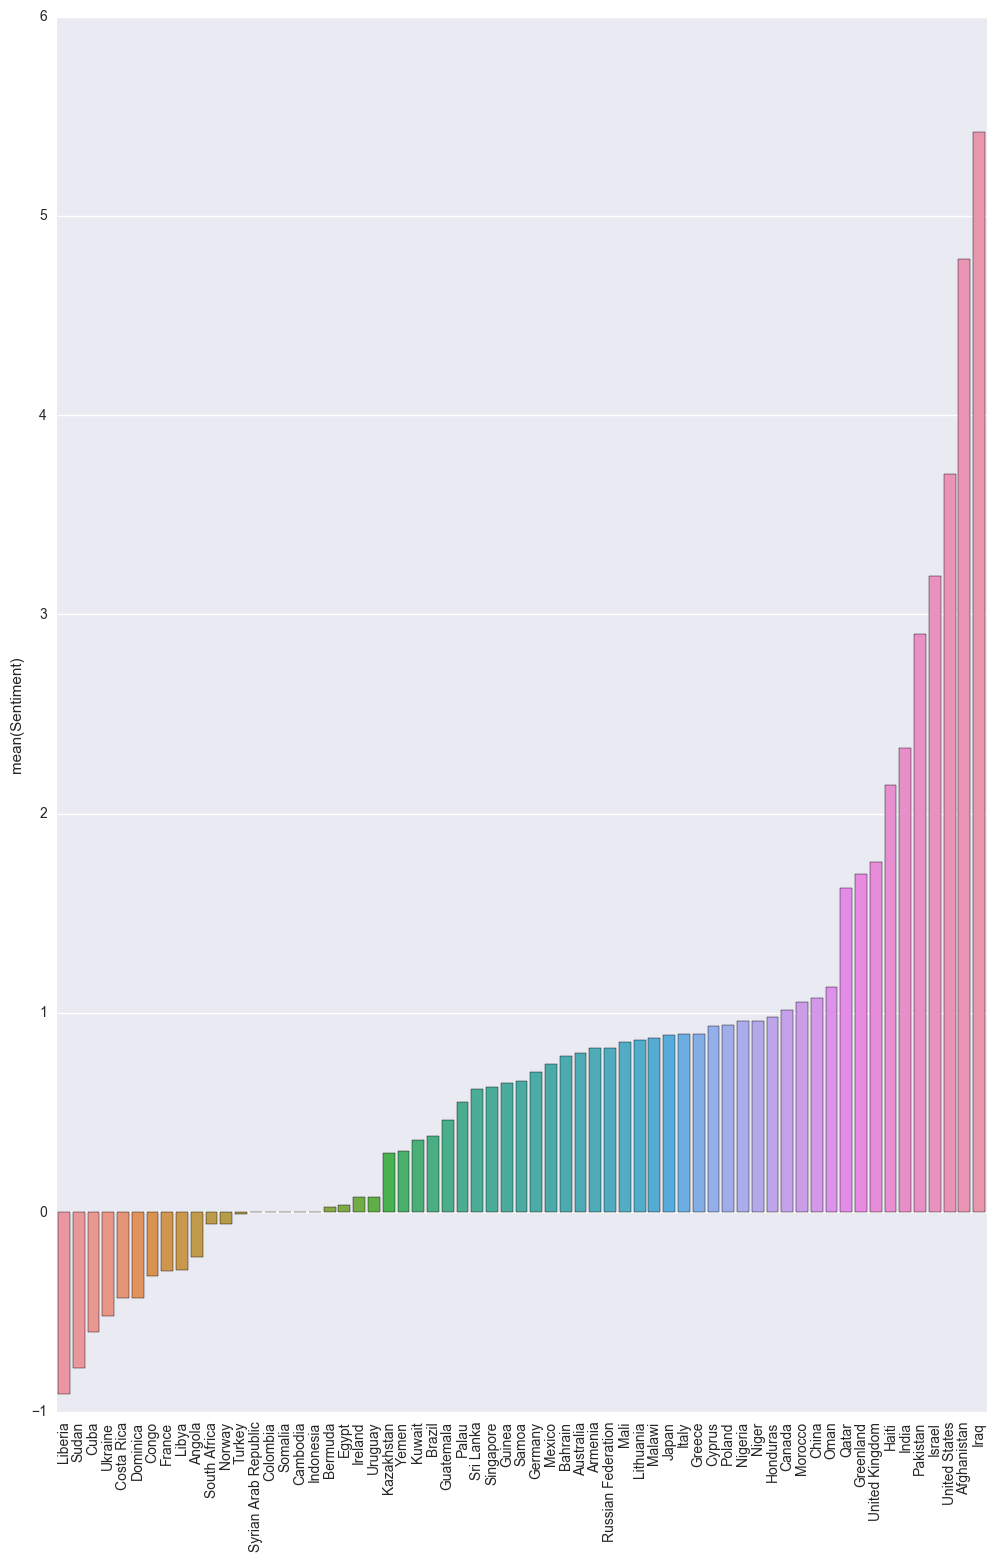

In [196]:
sns.barplot(x=df.index, y=df.Sentiment, data=df)
plt.xticks(rotation=90)

We could display the same scores but normilized by occurence of each country in emails to decrease the bayes

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]),
 <a list of 63 Text xticklabel objects>)

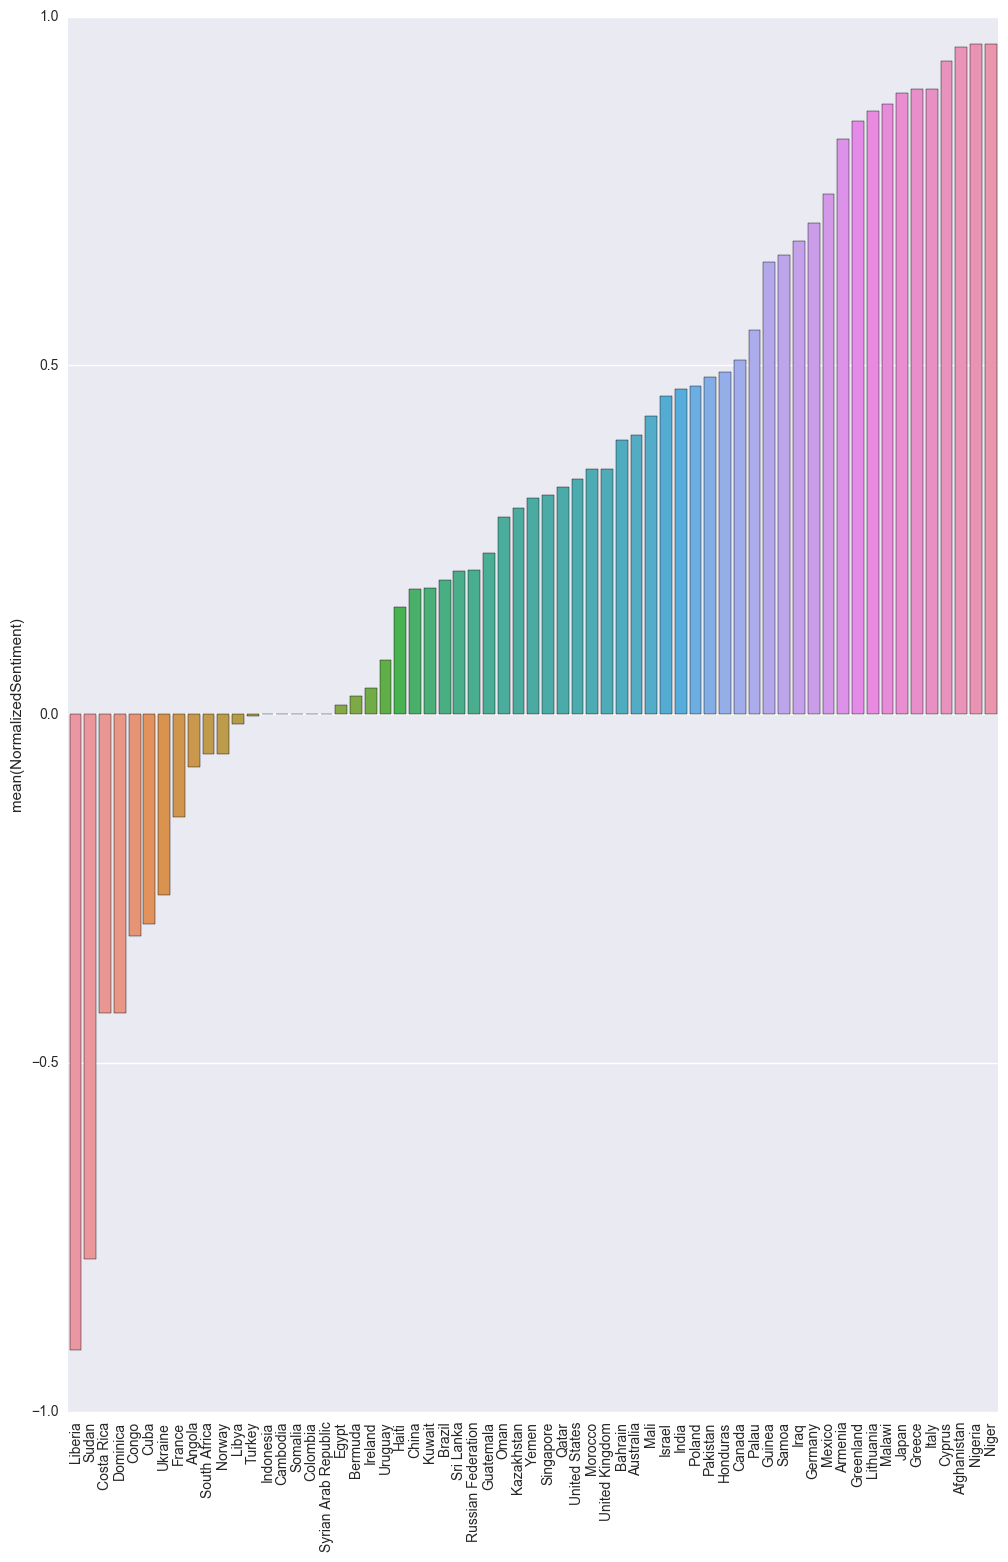

In [197]:
df['NormalizedSentiment']=df['Sentiment']/df['Freq']
df.sort_values(['NormalizedSentiment'],ascending=True, inplace=True)
sns.barplot(x=df.index, y=df.NormalizedSentiment, data=df)
plt.xticks(rotation=90)

Finaly we can build a bar plot showing how frequent each country has appeared and what was her sentiment score extracted from emails.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]),
 <a list of 63 Text xticklabel objects>)

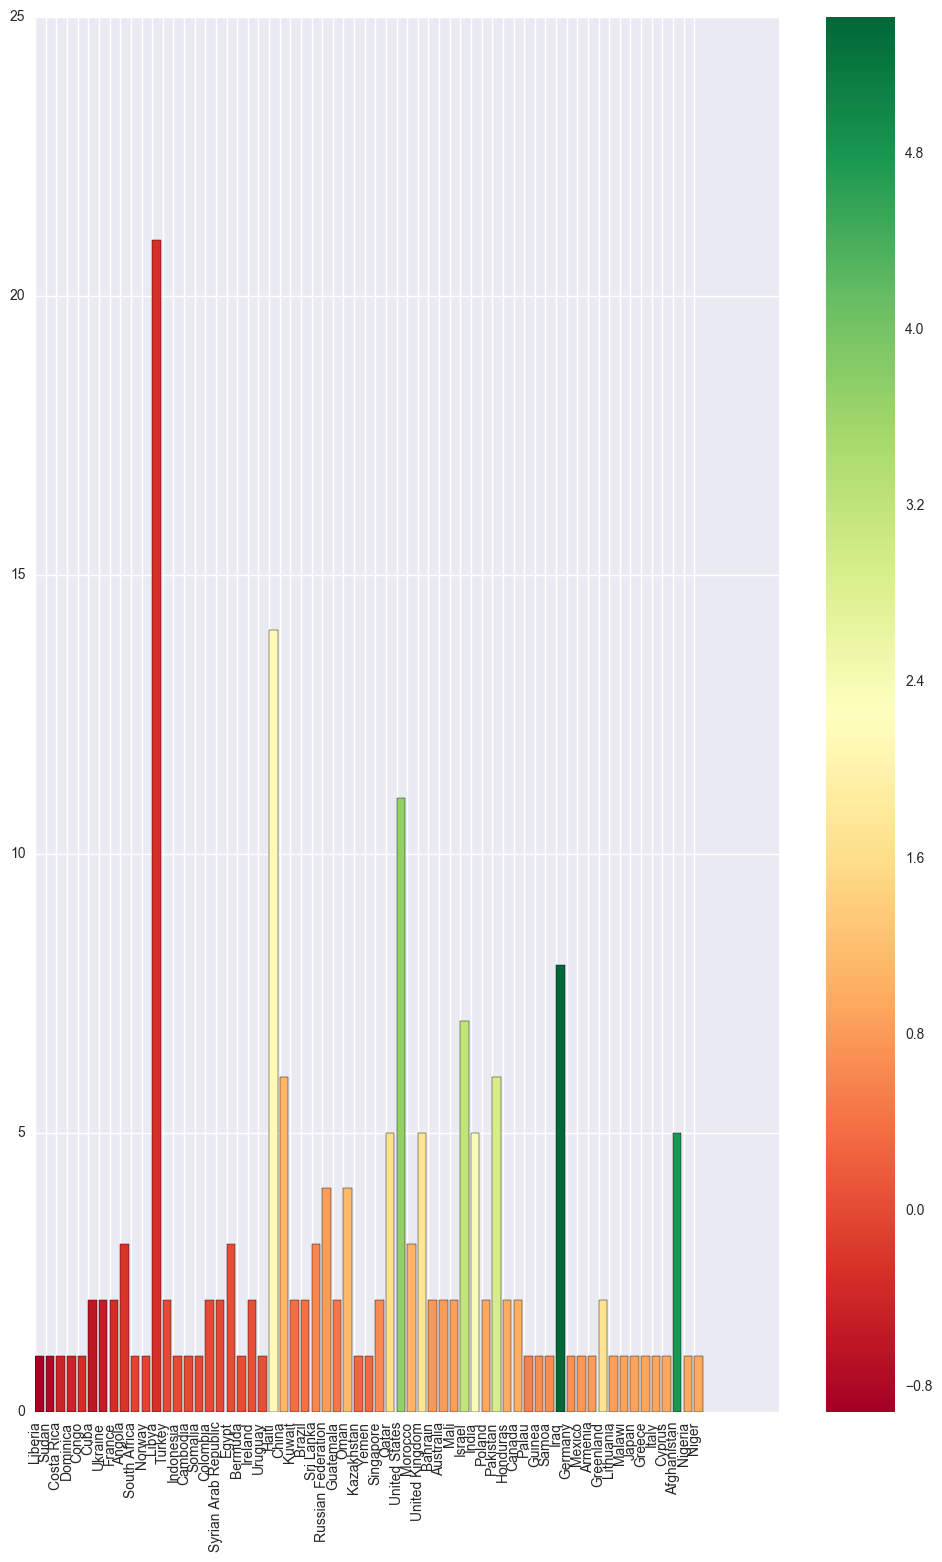

In [198]:
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=df.Sentiment.min(), vmax=df.Sentiment.max()))
sm.set_array(df.Sentiment)
plt.colorbar(sm)
plt.bar(left=range(len(df)), height=df.Freq, color=sm.to_rgba(df.Sentiment), tick_label=df.index)
plt.xticks(rotation=90)

Unfortunately demo_liu_hu_lexicon by default does not return any result but print one. To fix it we do a small modification of demo_liu_hu_lexicon function.

In [253]:
def demo_liu_hu_lexicon(sentence, plot=False):
    """
    Basic example of sentiment classification using Liu and Hu opinion lexicon.
    This function simply counts the number of positive, negative and neutral words
    in the sentence and classifies it depending on which polarity is more represented.
    Words that do not appear in the lexicon are considered as neutral.

    :param sentence: a sentence whose polarity has to be classified.
    :param plot: if True, plot a visual representation of the sentence polarity.
    """
    from nltk.corpus import opinion_lexicon
    from nltk.tokenize import treebank

    tokenizer = treebank.TreebankWordTokenizer()
    pos_words = 0
    neg_words = 0
    tokenized_sent = [word.lower() for word in tokenizer.tokenize(sentence)]

    x = list(range(len(tokenized_sent))) # x axis for the plot
    y = []

    for word in tokenized_sent:
        if word in opinion_lexicon.positive():
            pos_words += 1
            y.append(1) # positive
        elif word in opinion_lexicon.negative():
            neg_words += 1
            y.append(-1) # negative
        else:
            y.append(0) # neutral

    if pos_words > neg_words:
        return 'Positive'
    elif pos_words < neg_words:
        return 'Negative'
    elif pos_words == neg_words:
        return 'Neutral'

Now we can run this sentiment classifier through the emails.

In [256]:
df = sentiment_email_analysis(sentclsf='Other')
df.columns=['Sentiment','Freq']
df.sort_values(['Sentiment'],ascending=True, inplace=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]),
 <a list of 65 Text xticklabel objects>)

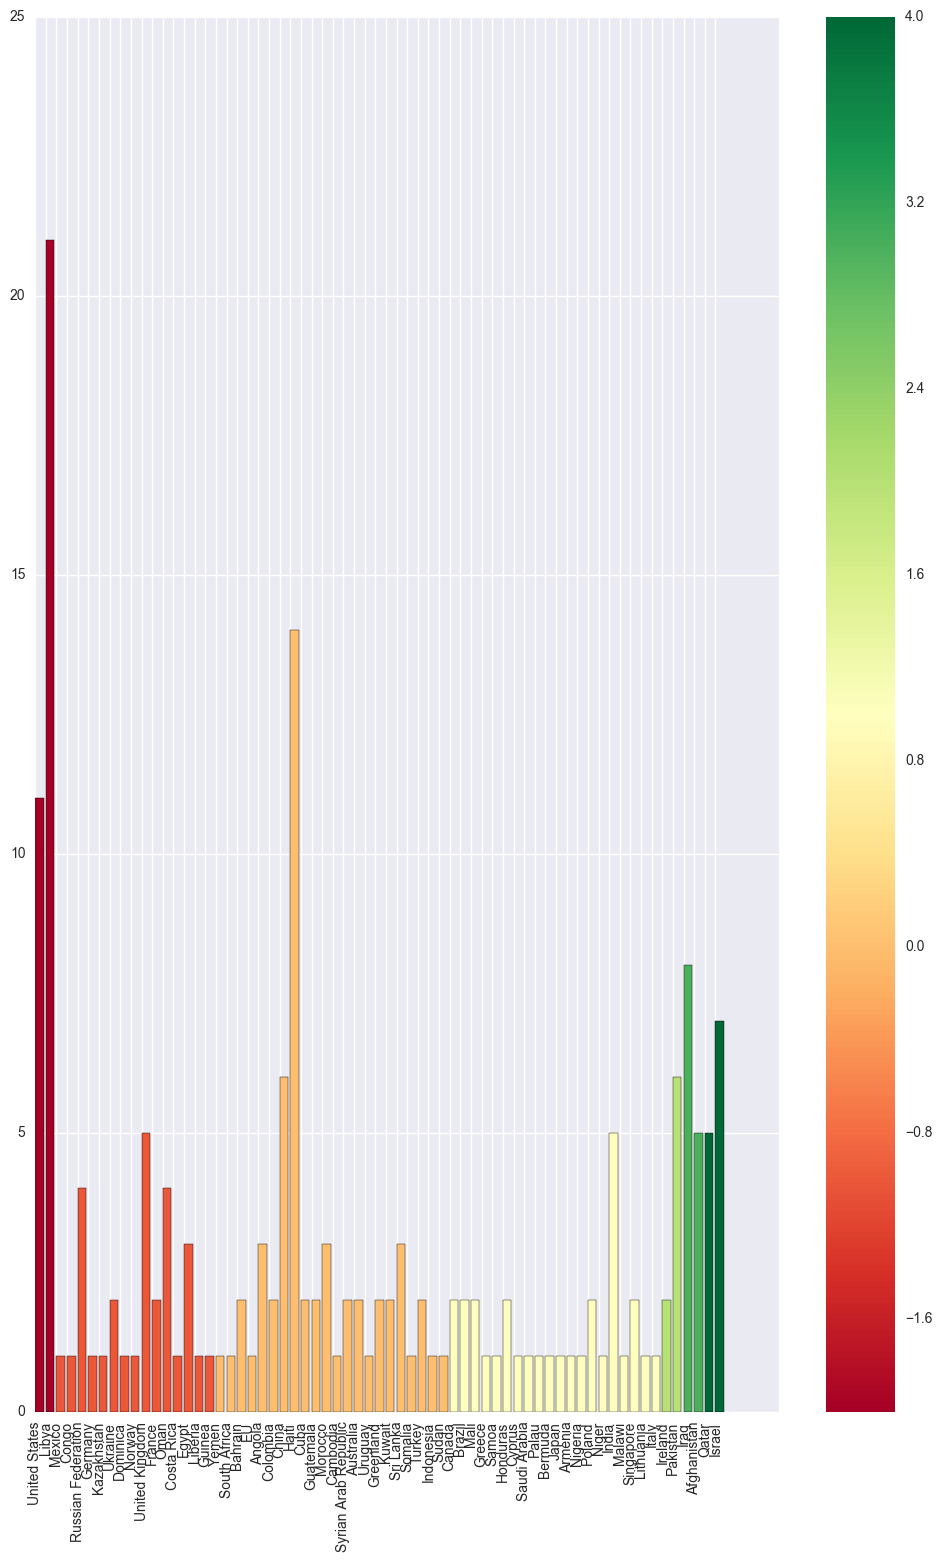

In [257]:
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=df.Sentiment.min(), vmax=df.Sentiment.max()))
sm.set_array(df.Sentiment)
plt.colorbar(sm)
plt.bar(left=range(len(df)), height=df.Freq, color=sm.to_rgba(df.Sentiment), tick_label=df.index)
plt.xticks(rotation=90)

If we compare two last charts we can see how some countries changed there group from positive to negative, see USA, some went more up, see Isreal. While most of the countries stayed more or less at the same group.